# Improving the convergence of the self-consistent iterations via Aitken's delta-squared process

In [1]:
import numpy as np
import numpy.ma as ma
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1927)

In [3]:
# get random core hamiltonian
h1e = np.random.rand(6, 6) + 1j * np.random.rand(6, 6)
h1e += h1e.conj().T

beta = 3

# select chemical potential
energies = linalg.eigvalsh(h1e)

mu = 0.3 * (energies.min() + energies.max())

In [4]:
def FermiDirac(E):
    return 1 / (1 + np.exp(beta * (E - mu)))

In [5]:
# get the FD for the core hamiltonian
rho_initial = linalg.funm(h1e, FermiDirac)

In [6]:
def do_self_consistent(rho, cc, niter=30):
    """
    rho - initial density matrix
    cc - coupling constant 
    """
    #print(linalg.norm(rho))
    #norm = [linalg.norm(rho)]
    norm_diff = []
    
    for _ in range(niter):
    
        previous_rho = rho.copy()
    
        
        # Hamiltonian with self-consistent corrections 
        h = h1e + cc * rho @ rho
        rho = linalg.funm(h, FermiDirac)
        
        norm_diff.append(linalg.norm(rho - previous_rho))
    
    plt.title("$\||\\rho_{current} - \\rho_{previous}\||$ as we iterate")
    plt.semilogy(norm_diff)
    plt.xlabel("iteration")
    plt.ylabel('$\||\\rho_{current} - \\rho_{previous}\||$')
    plt.show()
    
    
    return rho

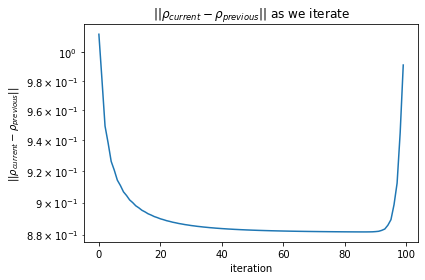

In [7]:
# note that if the coupling constant is low there is no problem
rho = do_self_consistent(rho_initial, 2, niter=100)

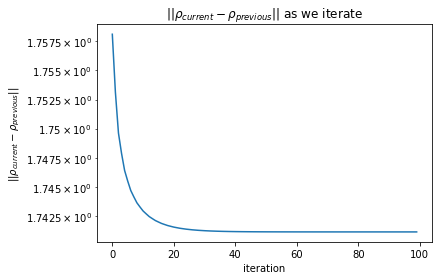

In [8]:
# if the coupling constant is high, we have a problem
rho = do_self_consistent(rho_initial, 4, niter=100)

# Solution: Let use [Aitken's $\Delta^2$-process](https://en.wikipedia.org/wiki/Aitken%27s_delta-squared_process) to improve the convergence 

In [9]:
def do_self_consistent_Aitken(rho, single_iteration, niter=50,):
    """
    Aitken's delta-squared process http://dlmf.nist.gov/3.9.iii
    :param rho: the initial guess (numpy.array)
    :param single_iteration: the right hand side function, f(rho), in the self-consistent iterations rho = f(rho) 
    :param niter: maximal number of iterations 
    :return: numpy.array -- the result of iterations
    """

    norm_diff = []
    
    rho_0 = rho.copy()
    
    for _ in range(niter):
        previous_aitken_rho = rho_0.copy()
        
        rho_1 = single_iteration(rho_0)
        rho_2 = single_iteration(rho_1)
        
        # use masked arrays to track entries which converged
        aitken_rho = rho_2 - (rho_2 - rho_1) ** 2 / ma.array(rho_2 + rho_0 - 2 * rho_1)
        
        aitken_rho = ma.filled(aitken_rho, fill_value=rho_2)
        
        rho_0 = aitken_rho
        
        norm_diff.append(linalg.norm(aitken_rho - previous_aitken_rho))
        
        if np.allclose(aitken_rho, previous_aitken_rho):
            print("Iterations converged!!!")
            break
        
    plt.title("$\||\\rho_{current} - \\rho_{previous}\||$ as we iterate")
    plt.semilogy(norm_diff)
    plt.xlabel("iteration")
    plt.ylabel('$\||\\rho_{current} - \\rho_{previous}\||$')
    plt.show()
    
    return aitken_rho

In [10]:
def single_iteration(rho_):
    h = h1e + 4 * rho_ @ rho_
    return linalg.funm(h, FermiDirac)

Iterations converged!!!


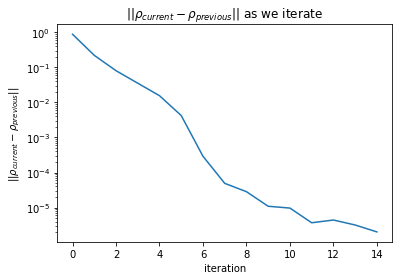

In [46]:
# this worked very well !!!!!
rho = do_self_consistent_Aitken(rho_initial, single_iteration,)

In [127]:
from mpmath import shanks, richardson

In [128]:
# Generate the sequence of self-consistent iterations
seq_rho = [rho_initial.copy()]

for _ in range(4):
    seq_rho.append(single_iteration(seq_rho[-1]))

In [129]:
norm_diff = [
    linalg.norm(previous - current) for previous, current in zip(seq_rho[:-1], seq_rho[1:])
]

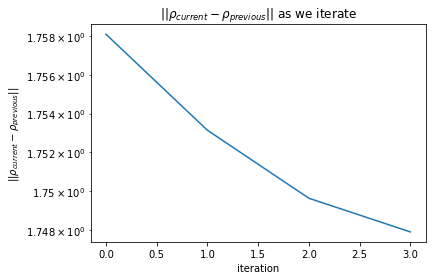

In [130]:
plt.title("$\||\\rho_{current} - \\rho_{previous}\||$ as we iterate")
plt.semilogy(norm_diff)
plt.xlabel("iteration")
plt.ylabel('$\||\\rho_{current} - \\rho_{previous}\||$')
plt.show()

In [131]:
shanks_final_rho = [
    [
        shanks([rho[k, m] for rho in seq_rho])[-1][-1]
        for k in range(rho.shape[0])
    ]
    for m in range(rho.shape[1])
]
shanks_final_rho = np.array(shanks_final_rho, dtype=np.complex)

In [132]:
richardson_final_rho = [
    [
        richardson([rho[k, m] for rho in seq_rho])[0]
        for k in range(rho.shape[0])
    ]
    for m in range(rho.shape[1])
]
richardson_final_rho = np.array(richardson_final_rho,  dtype=np.complex)

In [133]:
richardson_final_rho - shanks_final_rho

array([[ 0.34669163-1.20741886e-17j, -0.07575544+2.18587066e-02j,
        -0.06842029+1.34134611e-02j, -0.03283672-3.94799449e-02j,
        -0.08614664-2.79655404e-03j, -0.13590945-1.08780515e-02j],
       [-0.07575544-2.18587066e-02j,  0.37680953+3.28292029e-17j,
        -0.09548838+4.08424098e-02j, -0.02046666+9.00272953e-03j,
        -0.0285987 +4.63906949e-02j, -0.06319223-3.70929932e-02j],
       [-0.06842029-1.34134611e-02j, -0.09548838-4.08424098e-02j,
         0.31676664-7.06370739e-17j, -0.13150779+3.01639804e-02j,
        -0.04066334-4.33878253e-03j, -0.04080952-3.65543832e-03j],
       [-0.03283672+3.94799449e-02j, -0.02046666-9.00272953e-03j,
        -0.13150779-3.01639804e-02j,  0.28717229+2.71057730e-17j,
         0.00957579-7.04440453e-02j, -0.06053178+6.19772932e-02j],
       [-0.08614664+2.79655404e-03j, -0.0285987 -4.63906949e-02j,
        -0.04066334+4.33878253e-03j,  0.00957579+7.04440453e-02j,
         0.19824337+3.91931182e-18j, -0.01368657+3.21451543e-02j],
     

In [126]:
np.abs(shanks_final_rho - rho).max()

0.2073009076712706

In [116]:

np.abs(richardson_final_rho - rho).max()

0.27953176471153945

In [119]:
(shanks([rho[0, 0] for rho in seq_rho]))

[[mpc(real='-1.4445547342952878', imag='-1.2513736886835443e-17')],
 [mpc(real='1.4489107174772833', imag='-7.1188459503516656e-17'),
  mpc(real='0.35801394621964744', imag='1.2793213145225509e-17')],
 [mpc(real='-1.4523225907059349', imag='1.2591992056240603e-16'),
  mpc(real='0.35790025822121552', imag='1.6277312411513281e-17'),
  mpc(real='-8794.5543067973176', imag='-2.6956369073586157e-10')],
 [mpc(real='1.4541712920640162', imag='-3.9244132543687447e-19'),
  mpc(real='0.35808614975899572', imag='-5.0521263155817165e-18'),
  mpc(real='5378.0287013513016', imag='6.1724883048123742e-10'),
  mpc(real='0.3579708169894672', imag='1.1862280999716967e-17')],
 [mpc(real='-1.4558200308316049', imag='-6.5562694468239138e-17'),
  mpc(real='0.3580622597488633', imag='-1.2122790491842684e-17'),
  mpc(real='-41857.046283795331', imag='1.2388751532120736e-8'),
  mpc(real='0.3580649790505695', imag='-1.0328100822088658e-17'),
  mpc(real='15998.017137177805', imag='3.1199722795583043e-9')],
 [mpc(